In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from pathlib import Path
from scipy.io import loadmat
import re

from src.data_loader import CWRU_dataloader
from src.utils import load_config


class SignalVisualizer:
    """
    Visualizer for CWRU bearing signals with different preprocessing methods
    """
    
    def __init__(self, data_loader):
        """
        Args:
            data_loader: Instance of CWRU_dataloader
        """
        self.data_loader = data_loader
        
    def visualize_signals(self, preprocessing='raw', num_samples=3, file_list=None, mode='normal'):
        """
        Visualize signals with different preprocessing methods
        
        Args:
            preprocessing: 'raw', 'freq_spectrum', 'order_spectrum', 'order_spectrogram'
            num_samples: Number of samples to visualize per file
            file_list: List of file keys to visualize (e.g., ['97DE', '105DE'])
            mode: 'normal' or 'evolution' (evolution mode only for order_spectrum)
        """
        
        if file_list is None:
            print("Error: file_list is required")
            return
        
        # Special mode: order spectrum evolution (STFT-like)
        if mode == 'evolution' and preprocessing == 'order_spectrum':
            self._visualize_order_evolution(file_list)
            return
        
        # Normal mode: visualize samples
        if mode == 'evolution' and preprocessing != 'order_spectrum':
            print("Warning: Evolution mode only works with order_spectrum. Switching to normal mode.")
        
        # Get samples for visualization
        X_data, Y_data, common_axis = self.data_loader.get_samples_for_heatmap(preprocessing, file_list, num_samples)
        
        # Calculate number of samples per file
        samples_per_file = num_samples
        total_samples = len(file_list) * samples_per_file
        
        # Visualize each sample
        for idx in range(total_samples):
            file_idx = idx // samples_per_file
            sample_idx = idx % samples_per_file
            file_key = file_list[file_idx]
            
            # Get sample data
            sample_data = X_data[idx, 0, :]  # Shape: (channels, length) -> (length,)
            label = Y_data[idx]
            label_name = ['Normal', 'IR', 'OR'][label]
            
            # Create figure
            plt.figure(figsize=(12, 4))
            
            if preprocessing == 'order_spectrogram':
                # For spectrogram, data is 2D
                sample_data = X_data[idx, 0, :, :]  # Shape: (freq, time)
                
                # Colormap for spectrogram (you can change: 'viridis', 'jet', 'hot', 'plasma', 'magma')
                cmap = 'viridis'
                
                # Scale: linear or log (uncomment one)
                im = plt.imshow(sample_data, aspect='auto', origin='lower', cmap=cmap)
                # im = plt.imshow(np.log10(sample_data + 1e-10), aspect='auto', origin='lower', cmap=cmap)  # Log scale
                
                plt.colorbar(im, label='Magnitude')
                plt.xlabel('Time Frame')
                plt.ylabel('Order')
                plt.title(f'File: {file_key} | Label: {label_name} | Method: {preprocessing} | Sample {sample_idx+1}/{samples_per_file}')
                
            else:
                # For 1D signals (raw, freq_spectrum, order_spectrum)
                
                # Scale: linear or log (uncomment one)
                plt.plot(common_axis, sample_data, linewidth=0.8)
                # plt.semilogy(common_axis, sample_data, linewidth=0.8)  # Log scale for y-axis
                
                # Set labels based on preprocessing type
                if preprocessing == 'raw':
                    plt.xlabel('Time (s)')
                    plt.ylabel('Amplitude')
                elif preprocessing == 'freq_spectrum':
                    peaks, _ = find_peaks(sample_data, height=0.2 * np.max(sample_data), distance=3) # Điều chỉnh height và distance
                    for peak_x_idx in peaks:
                        peak_x = common_axis[peak_x_idx]
                        peak_y = sample_data[peak_x_idx]
                        plt.plot(peak_x, peak_y, "x", color='red') # Đánh dấu đỉnh bằng 'x' màu đỏ
                        plt.annotate(f'({peak_x:.2f}, {peak_y:.2f})', (peak_x, peak_y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')
                    plt.xlabel('Frequency (Hz)')
                    plt.ylabel('Magnitude')
                    plt.xlim([0, 6000])  # Limit to 6kHz for better visualization
                elif preprocessing == 'order_spectrum':
                    peaks, _ = find_peaks(sample_data, height=0.2 * np.max(sample_data), distance=3) # Điều chỉnh height và distance
                    for peak_x_idx in peaks:
                        peak_x = common_axis[peak_x_idx]
                        peak_y = sample_data[peak_x_idx]
                        plt.plot(peak_x, peak_y, "x", color='red') # Đánh dấu đỉnh bằng 'x' màu đỏ
                        plt.annotate(f'({peak_x:.2f}, {peak_y:.2f})', (peak_x, peak_y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')
                    plt.xlabel('Order')
                    plt.ylabel('Magnitude')
                    # plt.xlim([0, 20])  # Limit to order 50 for better visualization
                
                plt.grid(True, alpha=0.3)
                plt.title(f'File: {file_key} | Label: {label_name} | Method: {preprocessing} | Sample {sample_idx+1}/{samples_per_file}')
            
            plt.tight_layout()
            plt.show()
        
        return X_data, Y_data, common_axis
    
    def _visualize_order_evolution(self, file_list):
        """
        Visualize order spectrum evolution over time (STFT-like view)
        Creates a 2D heatmap showing how order spectrum changes throughout the file
        
        Args:
            file_list: List of file keys to visualize
        """
        base_path_obj = Path(self.data_loader.base_path)
        
        for file_key in file_list:
            # Load file data
            match = re.match(r'(\d+)(\w+)', file_key)
            if not match:
                print(f"Invalid file key: {file_key}")
                continue
                
            file_num_str, data_key_suffix = match.groups()
            glob_pattern = f'{file_num_str}_*.mat'
            found_files = list(base_path_obj.rglob(glob_pattern))
            
            if not found_files:
                print(f"[WARNING] No file found for '{file_key}'")
                continue
            
            file_path = found_files[0]
            label = self.data_loader.get_label_from_path(file_path)
            label_name = ['Normal', 'IR', 'OR'][label]
            
            # Load mat data
            mat_data = loadmat(file_path)
            mat_key_zfill = f'X{file_num_str.zfill(3)}_{data_key_suffix}_time'
            mat_key_normal = f'X{file_num_str}_{data_key_suffix}_time'
            
            if mat_key_zfill in mat_data:
                mat_key = mat_key_zfill
            elif mat_key_normal in mat_data:
                mat_key = mat_key_normal
            else:
                print(f"[WARNING] No time series key found for '{file_key}'")
                continue
            
            time_series = mat_data[mat_key].flatten()
            
            # Get RPM
            rpm = self.data_loader.default_rpm
            rpm_key_zfill = f'X{file_num_str.zfill(3)}_RPM'
            rpm_key_normal = f'X{file_num_str}_RPM'
            
            if rpm_key_zfill in mat_data:
                rpm = float(mat_data[rpm_key_zfill].flatten()[0])
            elif rpm_key_normal in mat_data:
                rpm = float(mat_data[rpm_key_normal].flatten()[0])
            else:
                for k in mat_data.keys():
                    if 'RPM' in k and not k.startswith('__'):
                        rpm = float(mat_data[k].flatten()[0])
                        break
            
            # Process with sliding window
            sample_length = self.data_loader.sample_length
            overlapping_ratio = 0.5  # 50% overlap for smooth evolution
            step = int(sample_length * (1 - overlapping_ratio))
            
            order_spectrums = []
            window_positions = []
            
            for i in range(0, len(time_series) - sample_length + 1, step):
                sample = time_series[i : i + sample_length]
                
                # Process through order spectrum pipeline
                signal_angular = self.data_loader._angular_resampling(sample, rpm)
                envelope = self.data_loader._envelope_extraction(signal_angular)
                spectrum = self.data_loader._spectrum(envelope)
                
                order_spectrums.append(spectrum)
                window_positions.append(i / self.data_loader.fs)  # Time position in seconds
            
            # Convert to 2D array: (time_windows, order_bins)
            order_evolution = np.array(order_spectrums).T  # Transpose to (order_bins, time_windows)
            
            # Create order axis
            order_axis_length = self.data_loader.resampling_output_size
            order_axis = np.arange(order_axis_length // 2) / self.data_loader.n_rev
            
            # Visualize
            plt.figure(figsize=(14, 6))
            
            # Colormap (you can change: 'viridis', 'jet', 'hot', 'plasma', 'magma', 'inferno')
            cmap = 'jet'
            
            # Scale: linear or log (uncomment one)
            im = plt.imshow(order_evolution, aspect='auto', origin='lower', cmap=cmap, 
                           extent=[window_positions[0], window_positions[-1], order_axis[0], order_axis[-1]])
            # im = plt.imshow(np.log10(order_evolution + 1e-10), aspect='auto', origin='lower', cmap=cmap,
            #                extent=[window_positions[0], window_positions[-1], order_axis[0], order_axis[-1]])  # Log scale
            
            plt.colorbar(im, label='Magnitude')
            plt.xlabel('Time (s)')
            plt.ylabel('Order')
            plt.title(f'Order Spectrum Evolution | File: {file_key} | Label: {label_name} | RPM: {rpm:.0f}')
            plt.ylim([0, 50])  # Limit to order 50 for better visualization
            
            plt.tight_layout()
            plt.show()
            
            print(f"Processed {file_key}: {len(order_spectrums)} windows, Shape: {order_evolution.shape}")


config = load_config('config/default_config.yaml')
data_loader = CWRU_dataloader(config['dataloader'])

# Create visualizer
viz = SignalVisualizer(data_loader)

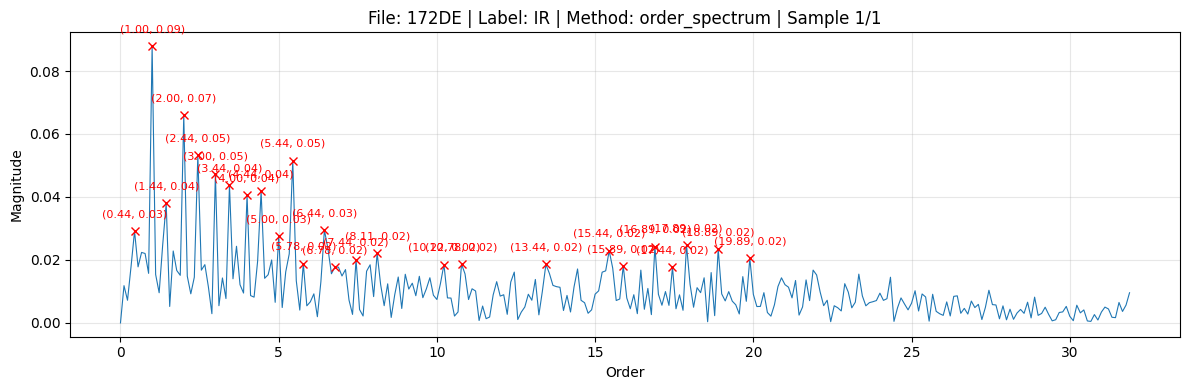

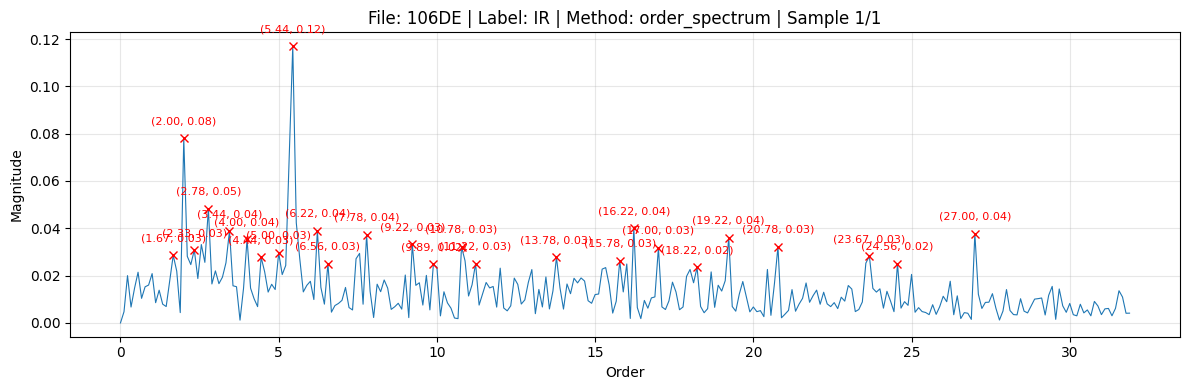

In [2]:
X, Y, x_axis = viz.visualize_signals(
    preprocessing='order_spectrum',
    num_samples=1,
    file_list=['172DE', '106DE'], #'209DE', '210DE', '211DE', '212DE'],
    mode='normal'
)

In [3]:
# viz.visualize_signals(
#     preprocessing='order_spectrum',
#     num_samples=1,
#     file_list=['105DE', '106DE', '107DE','108DE', '169DE', '170DE','171DE', '172DE', '209DE', '210DE', '211DE', '212DE'],
#     mode='normal'
# )

In [4]:
# viz.visualize_signals(
#     preprocessing='freq_spectrum',
#     num_samples=1,
#     file_list= ["144DE"
#     , "145DE"
#     , "146DE"
#     , "147DE"

#     , "130DE"
#     , "131DE"
#     , "132DE"
#     , "133DE"

#     , "156DE"
#     , "158DE"
#     ,"159DE"
#     ,"160DE"],
#     mode='normal'
# )

In [5]:
# viz.visualize_signals(
#     preprocessing='order_spectrum',
#     num_samples=1,
#     file_list= ["144DE"
#     , "145DE"
#     , "146DE"
#     , "147DE"

#     , "130DE"
#     , "131DE"
#     , "132DE"
#     , "133DE"

#     , "156DE"
#     , "158DE"
#     ,"159DE"
#     ,"160DE"],
#     mode='normal'
# )

In [6]:
# viz.visualize_signals(
#     preprocessing='order_spectrum',
#     num_samples=1,
#     file_list= ["246DE"
#     , "247DE"
#     , "248DE"
#     , "249DE"

#     , "234DE"
#     , "235DE"
#     , "236DE"
#     , "237DE"

#     , "258DE"
#     , "259DE"
#     , "260DE"
#     , "261DE"],
#     mode='normal'
# )

In [7]:
# viz.visualize_signals(
#     preprocessing='order_spectrum',
#     num_samples=2,
#     file_list= ['97DE', '98DE', '99DE', '100DE'],
#     mode='normal'
# )

✅ Loaded model from: experiments/models/best_model.pth
Using layer: conv3


c:\Users\Admin\anaconda3\envs\khanh-ifd\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


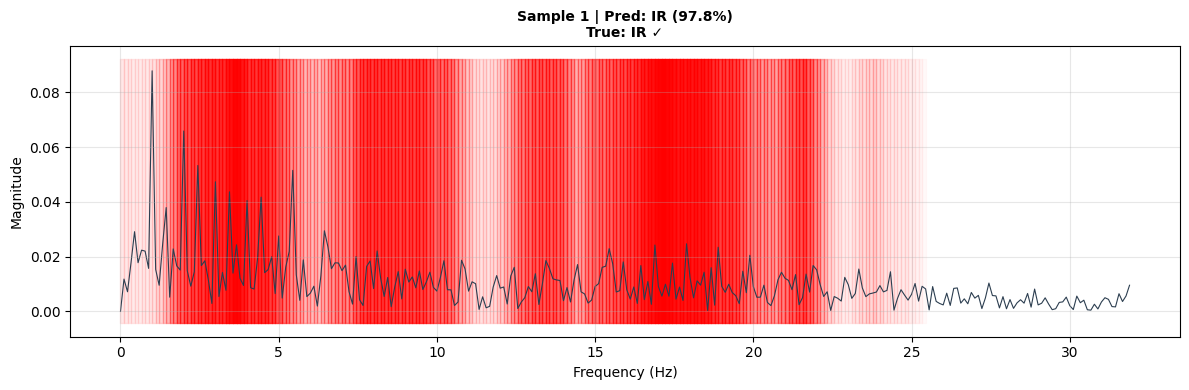

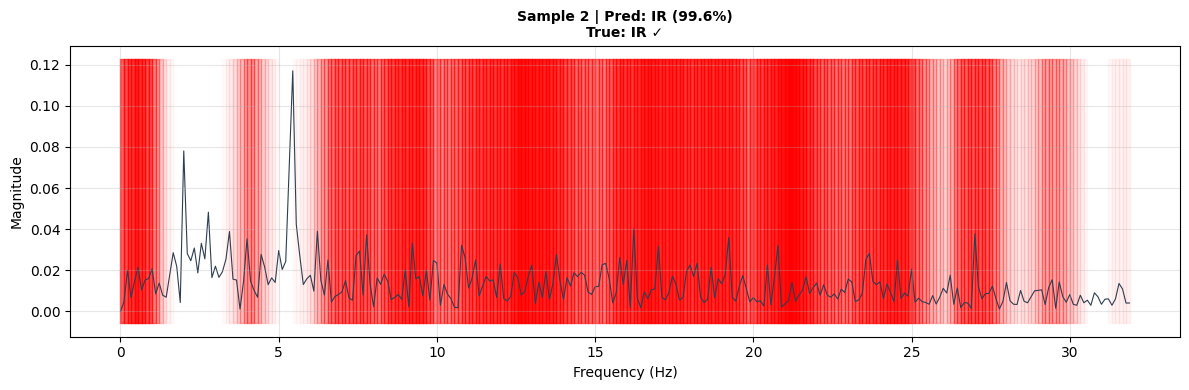


Visualization complete!
Target layer: Conv1d


In [8]:
import torch
from src import models
from src.heatmap import GradCAM1D, HeatmapVisualizer
import torch.nn.functional as F

import os

config = load_config('config/default_config.yaml')
model_path = "experiments/models/best_model.pth"   # đường dẫn file model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
model = models.SimpleCNN1D(1, num_classes).to(device)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()
print(f"✅ Loaded model from: {model_path}")

gradcam = GradCAM1D(model)

# Get predictions
tensor = torch.as_tensor(X, dtype=torch.float32)
tensor = tensor.to(device)
with torch.no_grad():
    outputs = model(tensor)
    probabilities = F.softmax(outputs, dim=1)
    predictions = outputs.argmax(dim=1)
    confidences = probabilities.max(dim=1)[0]

# Generate heatmaps
heatmaps = gradcam.generate_cam(tensor)

# Visualize
class_names = ['Normal', 'IR', 'OR']
visualizer = HeatmapVisualizer(class_names=class_names)

fname = config['heatmap']['name']
save_dir = os.path.join(".", "experiments", "heatmaps")
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, fname)
visualizer.plot_signal_with_heatmap(
    signals=tensor,
    heatmaps=heatmaps,
    predictions=predictions,
    confidences=confidences,
    true_labels=Y,
    x_axis=x_axis,
    xlabel="Frequency (Hz)",
    ylabel="Magnitude",
    save_path=save_path
)

print("\nVisualization complete!")
print(f"Target layer: {gradcam.target_layer.__class__.__name__}")

